# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


Resumen del profe: 
realizar una gráfica de los precios y observar el comportamiento.
El fenómeno del niño aumenta los precios, y los periodos con abundancia bajan los precios.
El precio pico es cuando ocurre un racionamiento de electricidad.

Existen dos tipos de sistemas, físicos (no se ven afectados y son estables), económicos (se ven afectados por la actividad humano).

La información pasada de los sistemas económicos no es tan confiable ya que las circunstancias cambian.

pt = C0 + C1pt_1 (la afirmación no es válida)
¿Cómo incorporar la obsolescencia de la información pasada? se debe usar un modelo adaptativo
¿Usar ADALINE? Modelo adaptativo

Hay que identificar qué problemas se pueden presentar.
-Crecimiento del precio por la inflación casi lineal. (Llevar los precios a moneda constante, ajustando por inflación)
Usar el IPC, banco de la república, en conjunto con una regla de tres
Pt = Po x IPCt/IPCo
-Poner todos los pesos respecto al primer IPC
-Tener en cuenta que el IPC cambia mensualmente.





Aplicar la transformación con logartimo natural (exponencial para devolverse) para corregir la serie y que sea más estable.
Otras transformacione son x^2, raíz cuadrada, cúbica.
Se debe usar la función que de un mejor pronóstico, para elegir la transformación se debe hacer lo siguiente:
- Datos, Transformación, Modelo, Pronóstico, Transformación Inversa, Evaluación del Error.


Para pronósticar los días, se pronóstica el primer día y en base a este el siguiente y así sucesivamente. Se debe tener en cuenta que el límite del pronóstico es limitado, ya que este terminaría convergiendo.


Pasos:
- Preprocesar datos para obtener el precio promedio diario.
- Eliminar la inflación con el IPC.
- Datos, Transformación, Modelo, Pronóstico, Transformación Inversa, Evaluación del Error.



Cuántos retardos o rezagos debo usar?
Realizar una tabla con las columnas, Orden del modelo, Error ajuste, Error pronóstico 7 días.
¿Cuál debe ser la tasa de aprendizaje?
¿Cuál debe ser el momentum?

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
%matplotlib inline

## Procesamiento de los datos

In [45]:

file_path = './datos/precios/Precio_Bolsa_Nacional_($kwh)_'

complete_df = None
for year in range(1995,2019):
    extension = 'xlsx'
    if (year >= 2016):
        extension = 'xls'
    filestring = file_path + str(year) +'.'+ extension
    skiprows=3
    if (year >= 2000):
        skiprows = 2
    df = pd.read_excel(filestring,skiprows=skiprows)
    means = []
    df = df.dropna(axis='index', thresh=10)
    df = df.dropna(axis='columns', how='all')
    for index, row in df.iterrows():
        s = 0
        c = 0
        for i in range(0,24):
            value = row[str(i)]
            if (not pd.isnull(value)):
                s += float(value)
                c += 1
        prom = s/c
        means.append(prom)
    df['Mean'] = means
    if (year == 1995):
        complete_df = df
    else:
        complete_df = complete_df.append(df)
parsed_dates = []
for d in complete_df['Fecha'].values:
    if (isinstance(d,str)):
        parsed_dates.append(datetime.datetime.strptime(d,"%Y-%m-%d"))
    elif (isinstance(d,datetime.datetime)):
        parsed_dates.append(d)
    else:
        print(d)
        print(type(d))
complete_df[¿]
#complete_df['Parsed Date'] = [if (isinstance(d,str)): datetime.datetime.strptime(d,"%Y-%m-%d") else: d for d in complete_df['Fecha'].values]        
complete_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,Mean,NaN,Unnamed: 26
count,8396.000000,8396.000000,8399.000000,8397.000000,8400.000000,8400.000000,8395.000000,8400.000000,8398.000000,8400.000000,...,8400.000000,8400.000000,8400.000000,8400.000000,8399.000000,8400.000000,8399.000000,8400.000000,365.000000,1096.000000
mean,94.894760,92.225018,90.481800,89.820847,91.875322,97.393668,98.849377,102.907985,107.703317,110.057409,...,110.170932,124.882346,132.515216,121.136281,113.722311,105.951791,99.023616,107.256202,75.013184,172.728791
std,123.549943,118.820196,117.353192,113.791278,114.577197,121.587657,121.585878,126.268919,131.341183,132.971299,...,133.585470,139.447157,140.298005,137.610502,135.153642,131.446948,125.436527,128.372835,21.329104,86.094551
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.499792,35.356674,38.397980
25%,37.347355,36.879062,36.364631,36.246583,37.321099,39.553350,39.958856,42.157859,45.211945,46.169674,...,46.145972,56.737062,62.877671,55.580568,49.984394,43.917158,39.039229,46.001686,59.497735,132.496797
50%,65.866872,64.739182,64.123530,63.978184,65.210519,67.996943,69.255438,71.540069,74.644855,76.273409,...,76.523747,90.169674,96.074484,85.976229,79.255884,72.459721,67.868907,74.653875,72.466983,162.804898
75%,116.394779,113.634484,111.184232,110.831014,113.713497,120.283444,122.090915,125.807304,130.596225,133.405265,...,133.612066,153.683890,166.491698,148.158058,136.762786,129.378072,123.197570,132.123855,89.774928,191.236969
max,1942.776133,1942.776133,1942.776133,1940.837460,1942.776133,1942.776133,1942.776133,1955.820551,2821.520551,1942.776133,...,1942.820551,1955.820551,1955.820551,1942.820551,1946.437460,1955.820551,1944.516236,1942.692800,130.143544,478.874958


In [42]:
complete_df.to_excel('../dataframe.xls')

Fecha           object
0              float64
1              float64
2              float64
3              float64
4              float64
5              float64
6              float64
7              float64
8              float64
9              float64
10             float64
11             float64
12             float64
13             float64
14             float64
15             float64
16             float64
17             float64
18             float64
19             float64
20             float64
21             float64
22             float64
23             float64
Mean           float64
Version         object
NaN            float64
Unnamed: 26    float64
dtype: object


TypeError: 'value' must be an instance of str or bytes, not a datetime.datetime

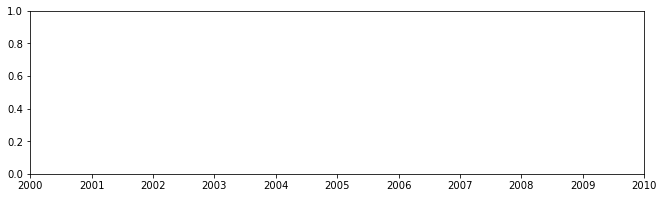

In [37]:
plt.figure(figsize=(11,3))
print(complete_df.dtypes)
plt.plot_date(complete_df['Fecha'],complete_df['Mean'], color='red');